In [1]:
%matplotlib inline

import os 
import warnings
import matplotlib as mpl

# Set default figure size 
mpl.rcParams['figure.figsize'] = [9.0, 6.0]

# Ignore warnings 
warnings.simplefilter("ignore")

# Location of the data directory on disk 
DATA = "data"

# Session 2: Information Extraction 
**June 21, 2018** 

In this session, we will take a deeper dive into the language processing toolkit to find ways to automatically extract and parse information from text. 

In the first session, we looked at ways of breaking down text into its constituent parts: documents into paragraphs, paragraphs into sentences, and sentences into token, tag tuples. We discovered that this data wrangling is the basis for discovering meaning in text through statistical techniques. For example, we explored the use of N-Gram analysis to find significant collocations. 

Text data contains a lot more information than simple collocations of words, such as parts-of-speech (e.g. what's a noun, a verb, and adjective, etc.). We can use linguistic information to start to build more complex data structures that will enable more effective parsing of text. We'll explore how to build syntax parses using NLTK, Stanford and spaCy to find dependencies between words that imply significant relationships. We will then use this information to summarize text, extract key phrases, and find named entities of interest. We can then link these entities together in a graph data structure, then use graph analysis techniques to find significant entities and their relationships. 

## Syntactic Parsing 

Assigning a structure to a sentence that reveals relationships governed by syntax rules, e.g. by grammars. Consider the sentence:

> The factory employs 12.8 percent of Bradford County.  

Syntax parses produce a tree that will enable us to understand that the subject of this sentence is "the factory", the predicate is "employs", and that the target is "12.8 percent", which in turn is modified by "Bradford County". 

### Syntax Parsing Challenges

Before we turn to how we conduct syntax parsing, we should note that parsing is a challenge, primarily because of **structural ambiguity**. Parsing, therefore is a stochastic machine learning technique that requires a lot of computational power.

While it is possible to develop a parser of your own in pure Python with NLTK (we'll explore some of this later). The libraries that exist to do this are generally black boxes. We'll look at two toolkits:

1. Stanford CoreNLP (with NLTK wrapper)
2. spaCy (dependency parsing only) 

![Constituency Parse](figures/s2_constituency_parsing.jpg)

A parse tree that distinguishes between terminal (phrases) and non-terminal (parts-of-speech) elements. Usually _deep_ and contain large amounts of _extra information_. 

![Dependency Parse](figures/s2_dependency_parsing.jpg)

Does not acknowledge difference between terminal (phrases) and non-terminal (parts-of-speech) elements. However, they are _simpler_ than constituency-based parse trees. 

### Stanford CoreNLP 

The Stanford CoreNLP package is written in Java 1.8 and contains one of the most advanced parsers for English, Arabic, Chinese, French, German, and Spanish. From Python, we can use CoreNLP by downloading the `.jar` files from [Stanford NLP download page](https://stanfordnlp.github.io/CoreNLP/#download) and wrapping the API servers that the JAR exposes with requests from NLTK.

> **NOTE**: If you don't have Java 1.8 installed or cannot download the CoreNLP packages, I would recommend skipping ahead to the Dependency Parsing section and using spaCy for parses. Not only is this pure Python, but it is more likely what you'll be using for parse analysis as well as machine learning. 

In [2]:
# Starting the CoreNLPServer 
from nltk.parse.corenlp import CoreNLPServer 

# The server needs to know the location of the following files:
#   - stanford-corenlp-X.X.X.jar 
#   - stanford-corenlp-X.X.X-models.jar 
STANFORD = os.path.join(DATA, "stanford-corenlp-full-2018-02-27")

# Create the server 
server = CoreNLPServer(
    os.path.join(STANFORD, "stanford-corenlp-3.9.1.jar"),
    os.path.join(STANFORD, "stanford-corenlp-3.9.1-models.jar"),    
)

# Start the server in the background 
server.start()

In [3]:
from nltk.parse.corenlp import CoreNLPParser 

parser = CoreNLPParser()
parse = next(parser.raw_parse("I put the book in the box on the table."))

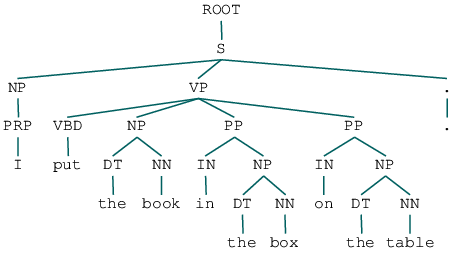

In [4]:
parse

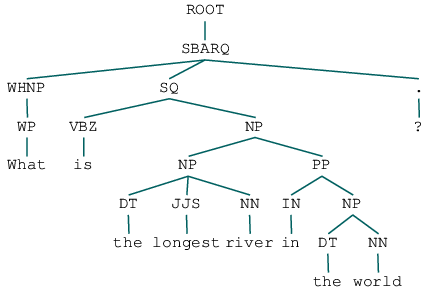

In [5]:
next(parser.raw_parse("What is the longest river in the world?"))

In [6]:
from nltk.parse.corenlp import CoreNLPDependencyParser 

parser = CoreNLPDependencyParser()
parse = next(parser.raw_parse("I put the book in the box on the table."))

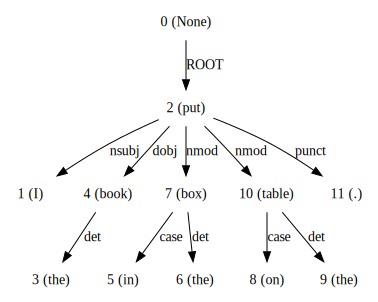

In [7]:
parse

In [8]:
# Stop the CoreNLP server 
server.stop()

### spaCy

spaCy is "industrial-strength natural language processing" and is built for speed and performance, particularly information extraction from large amounts of data. It is written in Cython, so it still needs to be compiled and installed, but at least it is all Python. 

In [9]:
import spacy 
from spacy import displacy

# Load the english language models
# Required: python -m spacy download en 
EN = spacy.load("en")

In [10]:
# Parse and analyze the sentence/document 
doc = EN("The apple dropped not far from his head.")

# Draw the dependency tree into the notebook 
displacy.render(doc, style='dep', minify=True, jupyter=True)

## spaCy Preprocessing

While we're here; we can review how to perform some of the preprocessing tasks we explored with NLTK last week, this time using spaCy: 

- Segmentation 
- Tokenization 
- Part of Speech Tagging 

In [11]:
from utils.wapo import save_wapo, load_wapo

save_wapo("2JEisx5", category="sports")
doc = EN(load_wapo("2JEisx5"))
doc

 Downtown Washington turned red Thursday afternoon and evening, as fans turned out in unprecedented numbers to watch Game 5 of the Stanley Cup finals. The area around Capital One Arena was packed for blocks in every direction; fans queued up in massive lines outside bars, restaurants, sandwich shops and liquor stores. They filled the G Street watch party between 7th and 9th Streets hours before the Washington Capitals began their quest to clinch their first Stanley Cup. Meanwhile, thousands poured into a different watch party inside the arena. Inside the arena, fans roared during every pregame clip of the Capitals, roared during every near miss, roared during the first intermission when Caps broadcasters led a round of “Let’s Go Caps!” chants. When Washington killed a second-period power play, the noise inside the arena was earsplitting. When Jakub Vrana scored on a breakaway moments later, the noise was … what’s louder than ear-splitting? VIDEO CELEBRATIONS | CELEBRITIES AND FORMER CA

In [12]:
sents = list(doc.sents)
print(len(sents))
print(sents[0])
print(sents[14])

166
 Downtown Washington turned red Thursday afternoon and evening, as fans turned out in unprecedented numbers to watch Game 5 of the Stanley Cup finals.
Chuck Brown’s “Bustin’ Loose” blared through the speaker system.


In [13]:
tokens = list(doc)
print(len(tokens))
print(tokens[12])

2134
turned


In [14]:
from tabulate import tabulate 

table = [["Text", "Lemma", "POS", "Tag", "Dep", "Alpha", "Stop"]]
for token in doc[:20]:
    table.append([
        token.text, token.lemma_, token.pos_, token.tag_, 
        token.dep_, token.is_alpha, token.is_stop
    ])
print(tabulate(table, tablefmt="simple", headers="firstrow"))

Text           Lemma          POS    Tag    Dep       Alpha    Stop
-------------  -------------  -----  -----  --------  -------  ------
                              SPACE                   False    False
Downtown       downtown       PROPN  NNP    compound  True     False
Washington     washington     PROPN  NNP    nsubj     True     False
turned         turn           VERB   VBD    ROOT      True     False
red            red            ADJ    JJ     acomp     True     False
Thursday       thursday       PROPN  NNP    compound  True     False
afternoon      afternoon      NOUN   NN     npadvmod  True     False
and            and            CCONJ  CC     cc        True     True
evening        evening        NOUN   NN     conj      True     False
,              ,              PUNCT  ,      punct     False    False
as             as             ADP    IN     mark      True     True
fans           fan            NOUN   NNS    nsubj     True     False
turned         turn           VERB  

## Parse Trees to Information 

Now that you have a parse tree, we can start using these structures to infer information of interest. We'll take a look at two related methods for detecting significant noun phrases:

- Named Entity Recognition and Classification (NERC) 
- Keyphrase extraction

## Named Entity Recognition 

![NER Classes](figures/s2_ner.png)

> "Speaker of the House of Representatives of the United States" 

> "The Good Ship Samantha sailed down the River Nile" 

### NER Tags 

There are many named entity tagsets from the simple (Wikipedia) to the more exetensive (OntoNotes). Here is a sample of commonly used tags:


| Tag          | Meaning                            | Example                      |
|--------------|------------------------------------|------------------------------|
| ORGANIZATION | Corporate actor, not single person | Apple, Inc., NYSE            |
| PERSON       | Individual or position             | Tom Smith, Captain Jones     |
| LOCATION     | Named point of interest            | Grand Canyon, Chesapeake Bay |
| DATE         | Any calendar representation        | October, 2014-12-25          |
| TIME         | Any clock representation           | two thirty am, 9:23 p.m.     |
| MONEY        | Any monetary representation        | 3 hundred dollars, GBP 10.40 |
| PERCENT      | Percentage representation          | twenty pct, 18.75%           |
| FACILITY     | Building point of interest         | Lincoln Memorial, Stonehenge |
| GPE          | Global political entity            | South East Asia, Maryland    |

### spaCy NER 

In [17]:
# Draw the dependency tree into the notebook 
displacy.render(doc, style='ent', minify=True, jupyter=True)

In [29]:
table = [["Tag", "Text", "Start", "End"]]
for ent in doc.ents[:20]:
    table.append([
        ent.label_, ent.text, ent.start_char, ent.end_char, 
    ])
print(tabulate(table, tablefmt="simple", headers="firstrow"))

Tag          Text                                        Start    End
-----------  ----------------------------------------  -------  -----
GPE          Washington                                     10     20
TIME         Thursday afternoon and evening                 32     62
LAW          Game 5                                        117    123
EVENT        the Stanley Cup                               127    142
FAC          Capital One Arena                             167    184
DATE         between 7th and 9th Streets hours before      357    397
ORG          the Washington Capitals                       398    421
ORDINAL      first                                         456    461
EVENT        Stanley Cup                                   462    473
CARDINAL     thousands                                     486    495
ORDINAL      first                                         672    677
PERSON       Caps                                          696    700
WORK_OF_ART  Let’s G

In [31]:
# Use explain to get the text description of a tag
spacy.explain("WORK_OF_ART")

'Titles of books, songs, etc.'

#### Accessing Entities 

Using the `doc.ents` property allows you to treat entities as entire tokens. The alternative is the IOB scheme, which allows you to scan between tokens to find NER relationships. 

- `I – Token is inside an entity.`
- `O – Token is outside an entity.`
- `B – Token is the beginning of an entity.`

In [40]:
table = [["Tag", "Text", "IOB", "End"]]
for token in EN("The Jefferson Memorial is located in Washington, D.C."):
    table.append([
        token.ent_type_, token.text, token.ent_iob_
    ])
print(tabulate(table, tablefmt="simple", headers="firstrow"))

Tag     Text        IOB
------  ----------  -----
PERSON  The         B
PERSON  Jefferson   I
PERSON  Memorial    I
        is          O
        located     O
        in          O
GPE     Washington  B
        ,           O
GPE     D.C.        B


### Training NER Models 

With a little effort, training a model to your specific NER use-case can have a large impact on the performance of your models and analytics. Although we won't go deep into the details in this session, it is worth considering conducting annotation activities at the start of projects so that improvements can be made toward the end of projects.

In [42]:
# spaCy doesn't recognize the name of the ship. 
phrase = EN("The Good Ship Samantha sailed down the River Nile")
displacy.render(phrase, style='ent', minify=True, jupyter=True)

In [46]:
from spacy.tokens import Span

ORG = phrase.vocab.strings["ORG"]        # get hash value of entity label
ship = Span(phrase, 0, 4, label=ORG)     # create a Span for the new entity
phrase.ents = list(phrase.ents) + [ship] # reset the entities on the phrase

displacy.render(phrase, style='ent', minify=True, jupyter=True)

### NLTK NER

In [59]:
from nltk import ne_chunk, word_tokenize, pos_tag

def ner(text, binary=False):
    text = pos_tag(word_tokenize(text))
    return ne_chunk(text, binary=binary)

print(ner("The Washington Capitals won their first Stanley Cup in the Capital One Arena."))

(S
  The/DT
  (ORGANIZATION Washington/NNP Capitals/NNP)
  won/VBD
  their/PRP$
  first/JJ
  Stanley/NNP
  Cup/NNP
  in/IN
  the/DT
  (ORGANIZATION Capital/NNP One/NNP Arena/NNP)
  ./.)


In [53]:
print(ner("The Washington Capitals won their first Stanley Cup in the Capital One Arena.", binary=True))

(S
  The/DT
  (NE Washington/NNP Capitals/NNP)
  won/VBD
  their/PRP$
  first/JJ
  Stanley/NNP
  Cup/NNP
  in/IN
  the/DT
  (NE Capital/NNP One/NNP Arena/NNP)
  ./.)


In [76]:
from nltk.tree import Tree 

def entities(text):
    for chunk in ner(text):
        if isinstance(chunk, Tree):
            label = chunk.label() 
            text = " ".join([token[0] for token in chunk.leaves()])
            yield label, text

            
chunks = entities("The Washington Capitals won their first Stanley Cup in the Capital One Arena.")
for chunk in chunks:
    print(chunk)

('ORGANIZATION', 'Washington Capitals')
('ORGANIZATION', 'Capital One Arena')


## Keyphrase Extraction 

Named entities are important parts of text analytics, but rely on a classification model in order to determine relevance. Often we want to be more general and simply extract the most important phrases in our document. There are two steps to do this:

1. Extract candidate phrases 
2. Score and rank phrases  

For an excellent writeup on key phrase extraction, see [Intro to Automatic Keyphrase Extraction by Burton de Wilde](http://bdewilde.github.io/blog/2014/09/23/intro-to-automatic-keyphrase-extraction/)

### Extract Candidates

There are many ways to extract candidates; we could use simple N-grams or simply create a filter of "good tags". A deeper candidate search would look at all phrase structures from a parse tree. In this case, we'll take advantage of our parse structure to find _noun phrases_ using a _grammar_ to get chunks from our trees: 

> `r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'`

This grammar defines a new tag, `KT` (key term) that can be composed of adjectives, nouns and prepositional phrases. 

In [114]:
import nltk 
import itertools

GRAMMAR = r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'

def candidates(sents, grammar=GRAMMAR, fileids=None):
    # Create our parser 
    chunker = nltk.chunk.regexp.RegexpParser(grammar)

    # Parse our tagged sentences and transform them into trees
    chunks  = list(itertools.chain.from_iterable(
        nltk.chunk.tree2conlltags(chunker.parse(sent))
        for sent in sents if sent
    ))
    
    # Filter other objects from the parse (only get candidates)
    def object_filter(group):
        word, pos, chunk = group
        return chunk != 'O'

    # Rejoin candidates as text
    return [
        " ".join(word for word, pos, chunk in group).lower()
        for key, group in itertools.groupby(chunks, object_filter) if key
    ]

In [115]:
from utils.reader import PickledCorpusReader

corpus = PickledCorpusReader("data/corpus")
# corpus = PickledCorpusReader("data/corpus/sample")

phrases = candidates(corpus.sents())
print(phrases[:10])
print(len(phrases))

['lonely city', 'heart', 'piercing wisdom', 'loneliness', 'laing', 'everyone', 'feast .” later', 'point', 'own hermetic existence in new york', '“']
323576


### Scoring Key Phrases 

As there are many methods for extracting phrases, there are a number of ways to rank and score them:

- Frequency Statistics 
- TF-IDF, BM25 
- Graph Ranking - PageRank, Betweenness 
- TextRank/DivRank 
- Classification - KEA 

For simplicity we'll rank using [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which uses the relative frequency of the term to the document compared to the rest of the corpus to score the phrse.

In [ ]:
import heapq 
import gensim 
from operator import itemgetter 


def rank_key_phrases(texts, N=20):
    id2word = gensim.corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    tfidf = gensim.models.TfidfModel(corpus)
    scored = tfidf[corpus]
    
    scores = [(term, score) for doc in scored for term, score in doc]
    table = [["Term", "Score"]]
    
    for wid, score in heapq.nlargest(N, scores, key=itemgetter(1)):
            table.append((id2word[wid], score))
    
    print(tabulate(table, tablefmt="simple", headers="firstrow"))

In [ ]:
phrases = [
    candidates(corpus.sents(fileids=fileid))
    for fileid in corpus.fileids()
]

rank_key_phrases(phrases)

## Summarization 

We can use key phrases to summarize text by ranking sentences by their key phrases and printing only those sentences as the summary. 

For this method, we'll use the slighly more advanced TextRank algorithm, available in Gensim.

In [132]:
from gensim.summarization import keywords

print(keywords(doc.text))

fans
fan
said
capital
capitals
arena
win
winning
wins
street
washington turned red
lines outside
sports
cup
like
stood
caps broadcasters
different
streets hours
johnson
years
year
game
watch
watching
inside
party
parties
finals
final
finally
celebrations
celebrities
celebration
celebrate
hour
post
championship
high police
national
nationals
stopped
stop
moments
moment
lined
fast
beers
beer
bowl
bowls
pregame
clothes
county
loose
travis
possible
centers
center
flip
ovechkin
bars
bar
screens
screening
crowds
crowd
super
wearing
chuck
lynx
wmata buses
spring native
period
long
wes
area
house
operating movie
address
hockey
vrana
broadcast
supporting
airport
food


In [123]:
from gensim.summarization import summarize

# NOTE: the doc is still a spaCy doc, we use the text attribute to get the raw data. 
summary = EN(summarize(doc.text))
print(summary)

Downtown Washington turned red Thursday afternoon and evening, as fans turned out in unprecedented numbers to watch Game 5 of the Stanley Cup finals.
The area around Capital One Arena was packed for blocks in every direction; fans queued up in massive lines outside bars, restaurants, sandwich shops and liquor stores.
They filled the G Street watch party between 7th and 9th Streets hours before the Washington Capitals began their quest to clinch their first Stanley Cup. Meanwhile, thousands poured into a different watch party inside the arena.
Inside the arena, fans roared during every pregame clip of the Capitals, roared during every near miss, roared during the first intermission when Caps broadcasters led a round of “Let’s Go Caps!” chants.
VIDEO CELEBRATIONS | CELEBRITIES AND FORMER CAPS | PREGAME AND WATCH PARTIES Outside, the fans weren’t just 20-somethings shotgunning beers.
As the final horn sounded, giving the Capitals a 4-3 victory over the Golden Knights and their first Stanl

In [124]:
print("Original length: {}".format(len(doc)))
print("Summary length: {}".format(len(summary)))

Original length: 2134
Summary length: 713


In [128]:
# Summary length by percent
print(summarize(doc.text, ratio=0.1))

Downtown Washington turned red Thursday afternoon and evening, as fans turned out in unprecedented numbers to watch Game 5 of the Stanley Cup finals.
As the final horn sounded, giving the Capitals a 4-3 victory over the Golden Knights and their first Stanley Cup championship, fans watching the game inside Capital One Arena stormed the court that hours earlier had hosted a WNBA game between the Washington Mystics and Minnesota Lynx.
Fans erupted in joy after watching the Capitals win their very first Stanley Cup outside the Capital One Arena.
(Michael Robinson Chavez/The Washington Post)  [Capitals win first Stanley Cup championship] Dwain Watts, 34, was at the National Portrait Gallery steps not long after midnight, holding up a copy of The Washington Post’s street edition.
“Even though I’m not a big sports fan and I don’t know much about hockey, it just felt like if you’re from the D.C. area, this was the thing you couldn’t miss,” she said.
“We just had a feeling about this time that 

In [129]:
# Summary length by word count
print(summarize(doc.text, word_count=50))

As the final horn sounded, giving the Capitals a 4-3 victory over the Golden Knights and their first Stanley Cup championship, fans watching the game inside Capital One Arena stormed the court that hours earlier had hosted a WNBA game between the Washington Mystics and Minnesota Lynx.


## Graph Analysis 

By modeling our data as entities and relationships, we can create graphs that allow us to more effectively reason about complex data and to make computations that would otherwise be impossible. 

Graph analytics is one of the first mechanisms of deep text analytics, particularly after information extraction reveals entities and their relationships. 

![Key Phrase Graph](figures/s2_keyphrase_rank_graph.png)

Key phrases associated with an article, sized by how many other documents contain the phrase.

![Email Graph](figures/s2_email_graph.png)

Email graph showing connections between emails and the clusters that form from frequent email groupings.

### Graph Extraction 

We'll explore a simple graph to start out with - our entities will be the named entities extracted by the default spaCy NER, and their relationships will be simply if they're in the same document together. 

In [174]:
def extract_entities(corpus, categories=None):
    for fileid in corpus.fileids(categories=categories):
        doc = EN(next(corpus.raw_data(fileid)))
        yield [
            ent for ent in doc.ents if ent.text.strip()
        ]

        
docs = extract_entities(corpus, "news")
next(docs)[:15]

[BERLIN,
 AP,
 Germany,
 Tuesday,
 second,
 first,
 60 years,
 German,
 16,
 the end of 2013,
 the National Democratic Party,
 NPD,
 2003,
 Karlsruhe,
 Federal Constitutional Court]

In [186]:
import networkx as nx 

def extract_graph(corpus, categories=None):
    G = nx.Graph() 
    
    for doc in extract_entities(corpus, "news"):
        for ent in doc:
            
            # Create the vertex in the graph 
            G.add_node(ent.lower_, text=ent.text, tag=ent.label_)
            
            # Create the edge to all other entities in the doc 
            for coent in doc:
                if ent == coent:
                    continue 
                G.add_edge(ent.lower_, coent.lower_) 
    
    return G 


# Warning: this may take a while! 
G = extract_graph(corpus, categories="news")
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 22276
Number of edges: 1381091
Average degree: 123.9981


In [188]:
import os 

GRAPH_DATA = os.path.join("data", "ner_news_graph.graphml")

# Save graph to disk 
nx.write_graphml(G, GRAPH_DATA)

# Load graph from disk 
G = nx.read_graphml(GRAPH_DATA)

### Centrality 

Centrality measures answer the question: "What are the most important entities in our graph?" 

In [194]:
def rank_entities(G, centrality, N=20):
    scores = centrality(G) 
    table = [["Term", "Score"]]
    
    for row in heapq.nlargest(N, scores.items(), key=itemgetter(1)):
            table.append(row)
    
    print(tabulate(table, tablefmt="simple", headers="firstrow"))

#### Degree Centrality 

Ranks nodes by how many other nodes they are connected to. 

A measure of popularity, determines nodes that can quickly spread information to a localized area.

In [195]:
rank_entities(G, nx.degree_centrality)

Term           Score
----------  --------
one         0.636768
first       0.619169
two         0.568305
three       0.397845
1           0.297059
000         0.282469
today       0.274388
four        0.27358
second      0.269764
2           0.250685
2014        0.248575
american    0.229315
friday      0.225589
u .         0.224602
last year   0.223659
tuesday     0.219798
five        0.213872
washington  0.208664
new york    0.204579
thursday    0.201706


#### Closeness Centrality 

Ranks nodes by how close they are to all other nodes in the graph.

A measure of reach; how fast information will spread to all other nodes from a single node.

In [ ]:
rank_entities(G, nx.closeness_centrality)

#### Betweenness Centrality 

Ranks nodes by how many shortest paths between all other nodes they are a part of. 

Shows which nodes are likely pathways of information and can be used to determine how a graph will break apart of nodes are removed.

In [ ]:
rank_entities(G, nx.betweenness_centrality)

#### Eigenvector Centrality 

Ranks nodes by the closeness of the node's neighbors (very similar to PageRank). 

A measure of related influence, who is closest to the most important people in the Graph? Kind of like “power behind the scenes” or influence beyond popularity.   

In [ ]:
rank_entities(G, nx.eigenvector_centrality)